<a href="https://colab.research.google.com/github/gnatnib/crop_yield_prediction/blob/main/crop_yield_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crop Yield Prediction - Regresi Interpolasi**
**Anggota Kelompok:**


*   Bintang Syafrian Rizal - 24060122120031
*   Awang Pratama Mulya    - 24060122120039
*   Muhammad Irfan Mursyid - 24060122130046



In [ ]:
#import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('/content/sample_data/yield_df.csv')

In [ ]:
df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [ ]:
def stratified_crop_sampling(df, n_samples=2000, random_state=42):
    """
    Perform stratified sampling on crop yield data to maintain representation
    across different areas and items (crops).

    Parameters:
    -----------
    df : pandas DataFrame
        The original dataset containing crop yield information
    n_samples : int
        Number of samples to select (default: 2000)
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    pandas DataFrame
        Sampled dataset maintaining proportions of areas and items
    """
    # Calculate the proportion of each Area-Item combination
    groupby_counts = df.groupby(['Area', 'Item']).size()
    total_records = len(df)

    # Calculate number of samples to take from each stratum
    samples_per_stratum = (groupby_counts / total_records * n_samples).round().astype(int)

    # Adjust to ensure we get exactly n_samples
    while samples_per_stratum.sum() != n_samples:
        if samples_per_stratum.sum() > n_samples:
            # Remove one sample from the largest stratum
            max_stratum = samples_per_stratum.idxmax()
            samples_per_stratum[max_stratum] -= 1
        else:
            # Add one sample to the smallest non-zero stratum
            min_stratum = samples_per_stratum[samples_per_stratum > 0].idxmin()
            samples_per_stratum[min_stratum] += 1

    # Sample from each stratum
    sampled_data = []
    for (area, item), n in samples_per_stratum.items():
        if n > 0:
            stratum = df[(df['Area'] == area) & (df['Item'] == item)]
            # If n is larger than the stratum size, take all records
            if n >= len(stratum):
                sampled_data.append(stratum)
            else:
                sampled = stratum.sample(n=n, random_state=random_state)
                sampled_data.append(sampled)

    # Combine all sampled data
    final_sample = pd.concat(sampled_data, axis=0)

    return final_sample

def verify_sampling(original_df, sampled_df):
    """
    Verify the quality of sampling by comparing distributions
    of key features in original and sampled datasets.

    Parameters:
    -----------
    original_df : pandas DataFrame
        The original dataset
    sampled_df : pandas DataFrame
        The sampled dataset

    Returns:
    --------
    dict
        Dictionary containing comparison metrics
    """
    metrics = {
        'total_samples': len(sampled_df),
        'unique_areas': {
            'original': len(original_df['Area'].unique()),
            'sampled': len(sampled_df['Area'].unique())
        },
        'unique_items': {
            'original': len(original_df['Item'].unique()),
            'sampled': len(sampled_df['Item'].unique())
        },
        'year_range': {
            'original': (original_df['Year'].min(), original_df['Year'].max()),
            'sampled': (sampled_df['Year'].min(), sampled_df['Year'].max())
        }
    }

    return metrics

# **Data Cleaning**

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


In [ ]:
df.isnull().sum()

,0
Area,0
Item,0
Year,0
hg/ha_yield,0
average_rain_fall_mm_per_year,0
pesticides_tonnes,0
avg_temp,0


In [ ]:
df.duplicated().sum()

2310

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(25932, 7)

In [ ]:
df.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,25932.000000,25932.000000,25932.000000,25932.000000,25932.000000
mean,2001.556455,76978.132925,1146.836688,34782.573241,20.422251
std,7.055924,84647.605552,717.391098,57228.568244,6.439402
min,1990.000000,50.000000,51.000000,0.040000,1.300000
25%,1995.000000,19996.000000,593.000000,1597.000000,16.580000
50%,2001.000000,39530.000000,1083.000000,15373.000000,21.420000
75%,2008.000000,104168.000000,1668.000000,45620.000000,26.060000
max,2013.000000,501412.000000,3240.000000,367778.000000,30.650000


In [ ]:
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

print(correlation_matrix)

                                   Year  hg/ha_yield  \
Year                           1.000000     0.091327   
hg/ha_yield                    0.091327     1.000000   
average_rain_fall_mm_per_year -0.006423    -0.004067   
pesticides_tonnes              0.135127     0.065523   
avg_temp                       0.013701    -0.110400   

                               average_rain_fall_mm_per_year  \
Year                                               -0.006423   
hg/ha_yield                                        -0.004067   
average_rain_fall_mm_per_year                       1.000000   
pesticides_tonnes                                   0.161483   
avg_temp                                            0.333694   

                               pesticides_tonnes  avg_temp  
Year                                    0.135127  0.013701  
hg/ha_yield                             0.065523 -0.110400  
average_rain_fall_mm_per_year           0.161483  0.333694  
pesticides_tonnes                 

# **Data Visualization**

In [ ]:
len(df['Area'].unique())

101

<ipython-input-16-c9a5afd84a7a>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g1.get_xticklabels(), rotation=90)


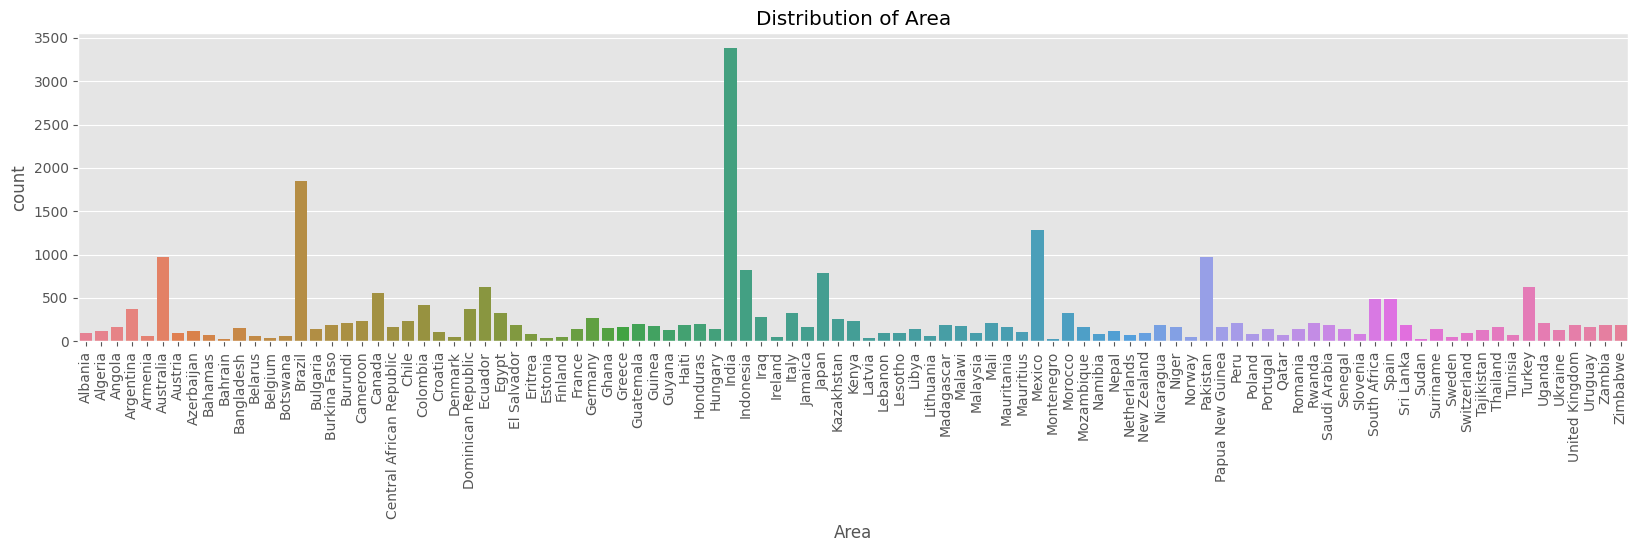

In [ ]:
plt.figure(figsize=(20,4))
g1 = sns.countplot(x=df['Area'], hue=df['Area'], legend=False)
g1.set_title('Distribution of Area')

g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
plt.show()

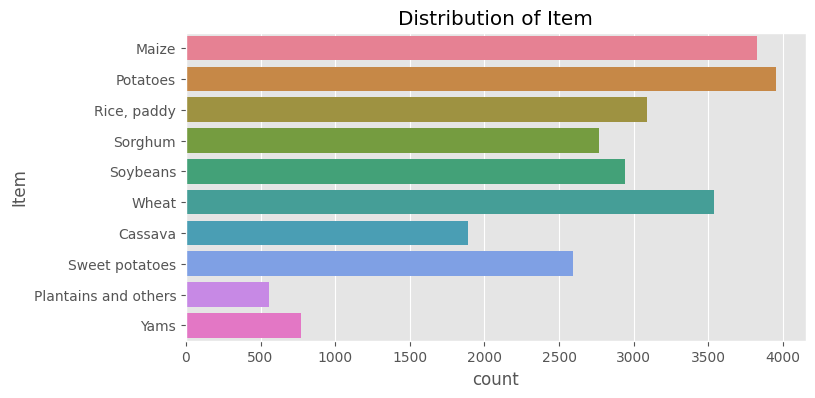

In [ ]:
plt.figure(figsize=(8,4))
g2 = sns.countplot(y=df['Item'], hue=df['Item'], legend=False)
g2.set_title('Distribution of Item')
plt.show()

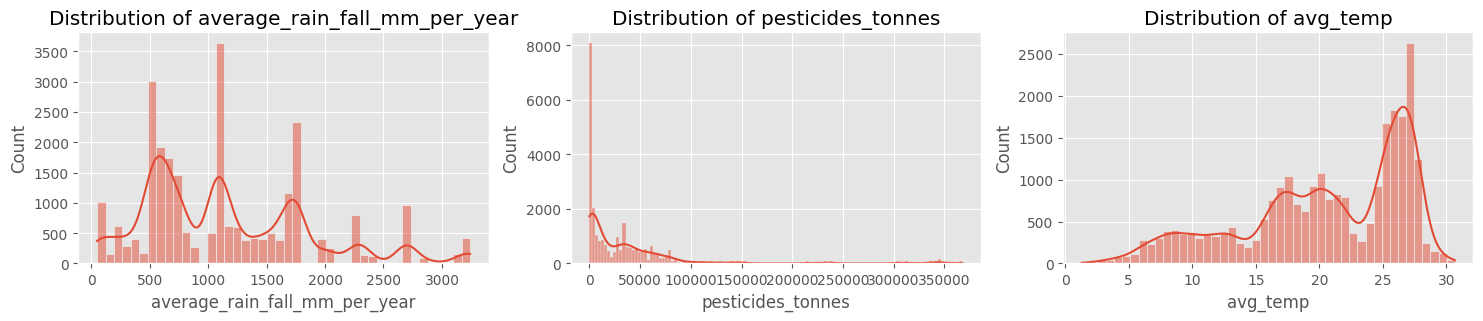

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))

g1=sns.histplot(df["average_rain_fall_mm_per_year"], kde=True, ax=axes[0])
g2=sns.histplot(df["pesticides_tonnes"], kde=True, ax=axes[1], label='Data')
g3=sns.histplot(df["avg_temp"], kde=True, ax=axes[2], label='Data')


g1.set_title("Distribution of average_rain_fall_mm_per_year")
g2.set_title("Distribution of pesticides_tonnes")
g3.set_title("Distribution of avg_temp")

plt.show()

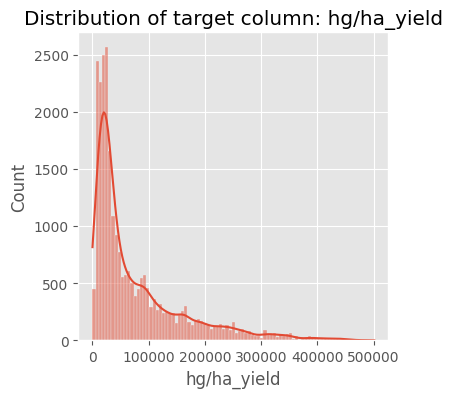

In [ ]:
plt.figure(figsize=(4, 4))
g=sns.histplot(df["hg/ha_yield"], kde=True, label='Data')
g.set_title("Distribution of target column: hg/ha_yield")

plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

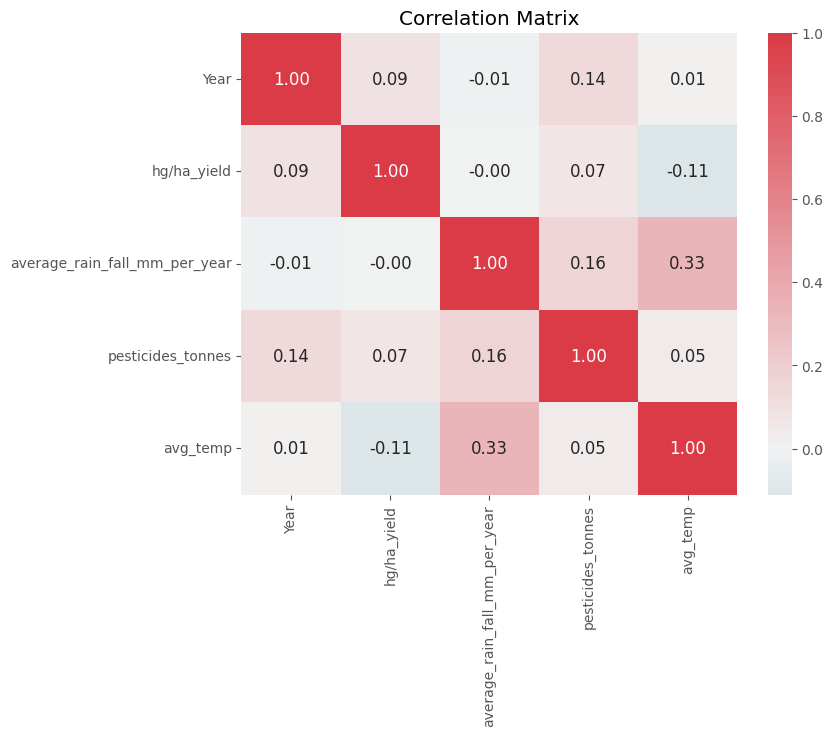

In [ ]:
#Correlation Matrix
corr_matrix = df.drop(['Area', 'Item'], axis=1).corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f", center = 0, annot_kws={"size": 12}).set_title('Correlation Matrix')

In [ ]:
(df['Area'].value_counts() < 400).sum()

88

In [ ]:
country = df['Area'].unique()
yield_per_country = []
for state in country:
    yield_per_country.append(df[df['Area'] == state]['hg/ha_yield'].sum())

In [ ]:
df['hg/ha_yield'].sum()

1996196943

In [ ]:
#Yield per country
import ipywidgets as widgets
from IPython.display import display

area_dropdown = widgets.Dropdown(options=df['Area'].unique(), description='Area:')
item_dropdown = widgets.Dropdown(options=df['Item'].unique(), description='Item:')

def plot_data(area, item):
    plt.figure(figsize=(10,6))
    temp_df = df[(df['Area'] == area) & (df['Item'] == item)]
    plt.plot(temp_df['Year'], temp_df['hg/ha_yield'])
    plt.title(f'hg/ha_yield over the years for {item} in {area}')
    plt.xlabel('Year')
    plt.ylabel('hg/ha_yield')
    plt.grid(True)
    plt.show()

widgets.interactive(plot_data, area=area_dropdown, item=item_dropdown)

interactive(children=(Dropdown(description='Area:', options=('Albania', 'Algeria', 'Angola', 'Argentina', 'Arm…

In [ ]:
#Sum of all yield per country
yield_per_country

[5711536,
 6711464,
 5722563,
 32864032,
 4524100,
 109111062,
 10852258,
 4608380,
 4384717,
 4443889,
 7720159,
 4704812,
 8442270,
 470651,
 136340329,
 6263075,
 6083337,
 7031146,
 10717883,
 34706922,
 4255627,
 20561214,
 26927138,
 6083167,
 10701651,
 25312166,
 21315591,
 36828848,
 16855944,
 1452416,
 3595638,
 6210668,
 15790618,
 38780463,
 9260371,
 14571925,
 16508723,
 7975743,
 8361103,
 8619194,
 10920131,
 8824110,
 274219558,
 68067328,
 10984722,
 9104030,
 32280700,
 19698007,
 100924145,
 9965212,
 14391737,
 3698588,
 6956804,
 4258932,
 9016288,
 4174348,
 6103523,
 8346715,
 7934982,
 15106720,
 4465841,
 12684212,
 113698872,
 1645100,
 22173010,
 6964027,
 3165475,
 4113713,
 14086433,
 17657728,
 12819227,
 12316327,
 6721305,
 49264956,
 10729929,
 15201910,
 6564711,
 12154347,
 5995626,
 6006156,
 7741053,
 15171886,
 10342677,
 7197013,
 30999849,
 46773540,
 11217741,
 1896346,
 14786468,
 8620653,
 13336346,
 6295210,
 9511720,
 3724246,
 52263950,
 

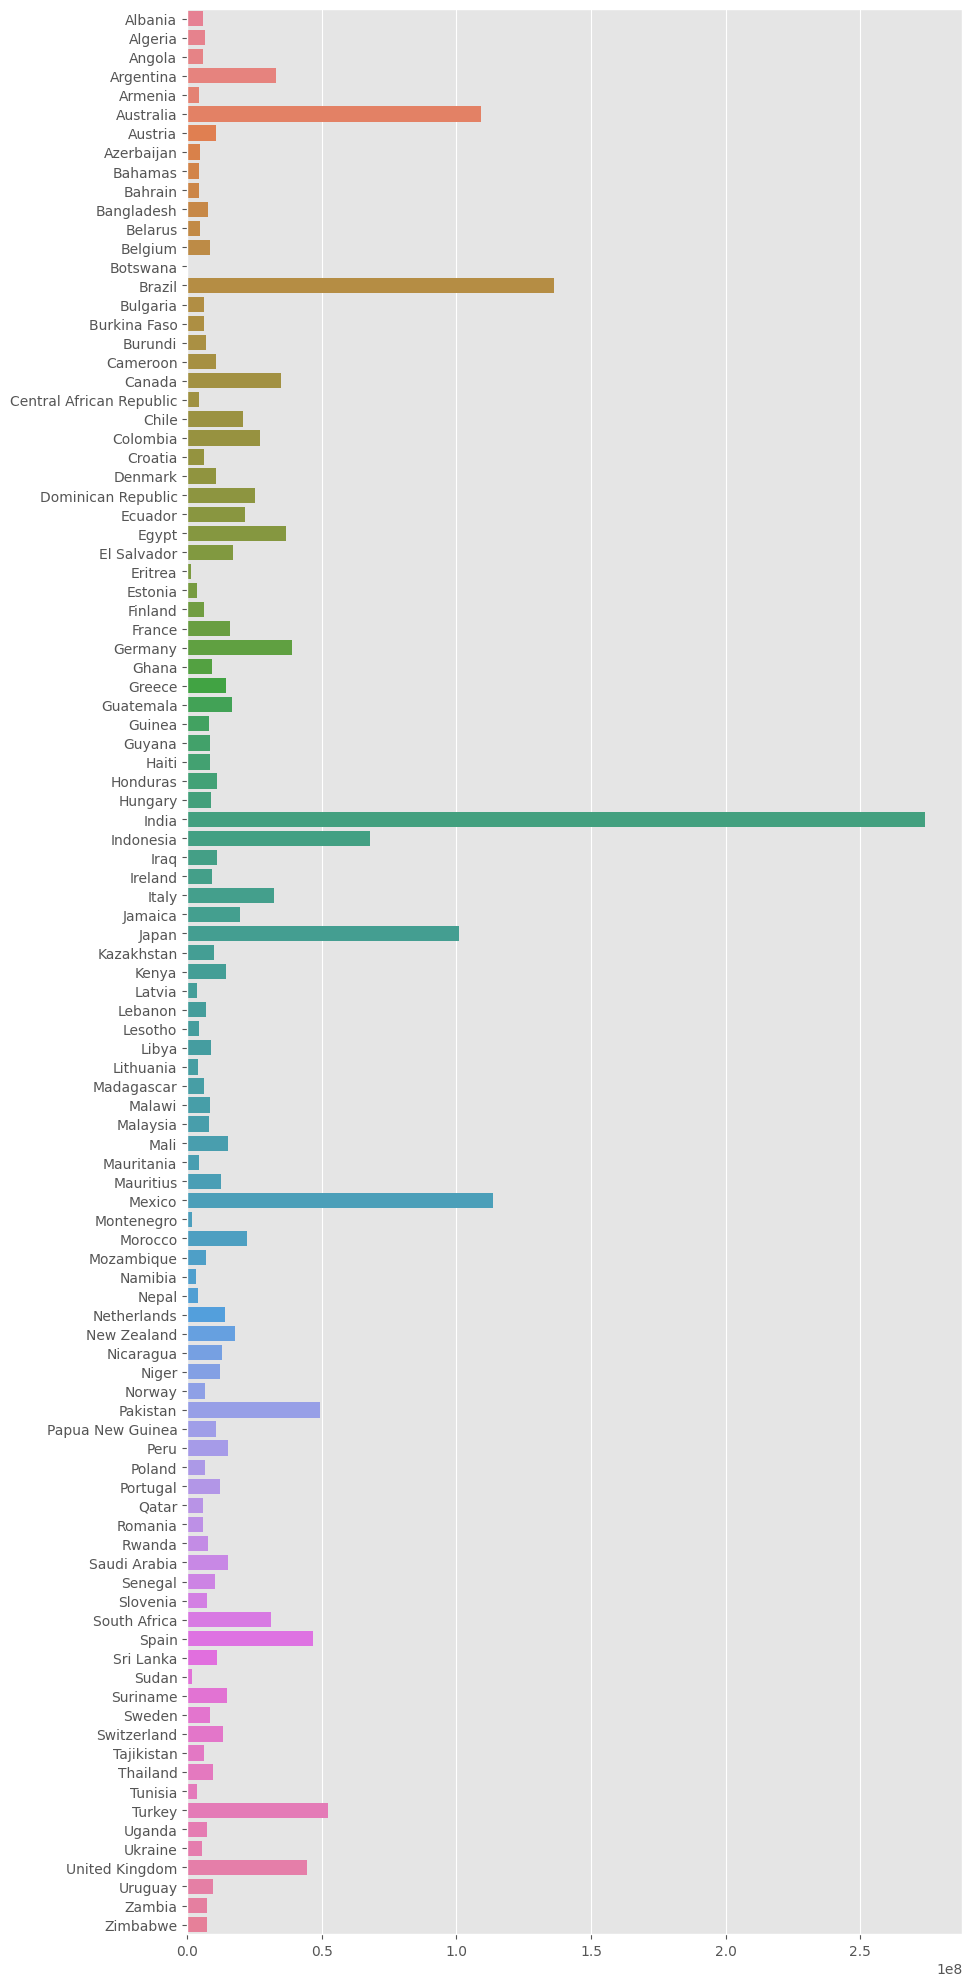

In [ ]:
plt.figure(figsize=(10,25))
sns.barplot(y=country, x=yield_per_country, hue=country, dodge=False)
plt.show()

In [ ]:
crops = df['Item'].unique()
yield_per_crop = []
for crop in crops:
    yield_per_crop.append(df[df['Item'] == crop]['hg/ha_yield'].sum())

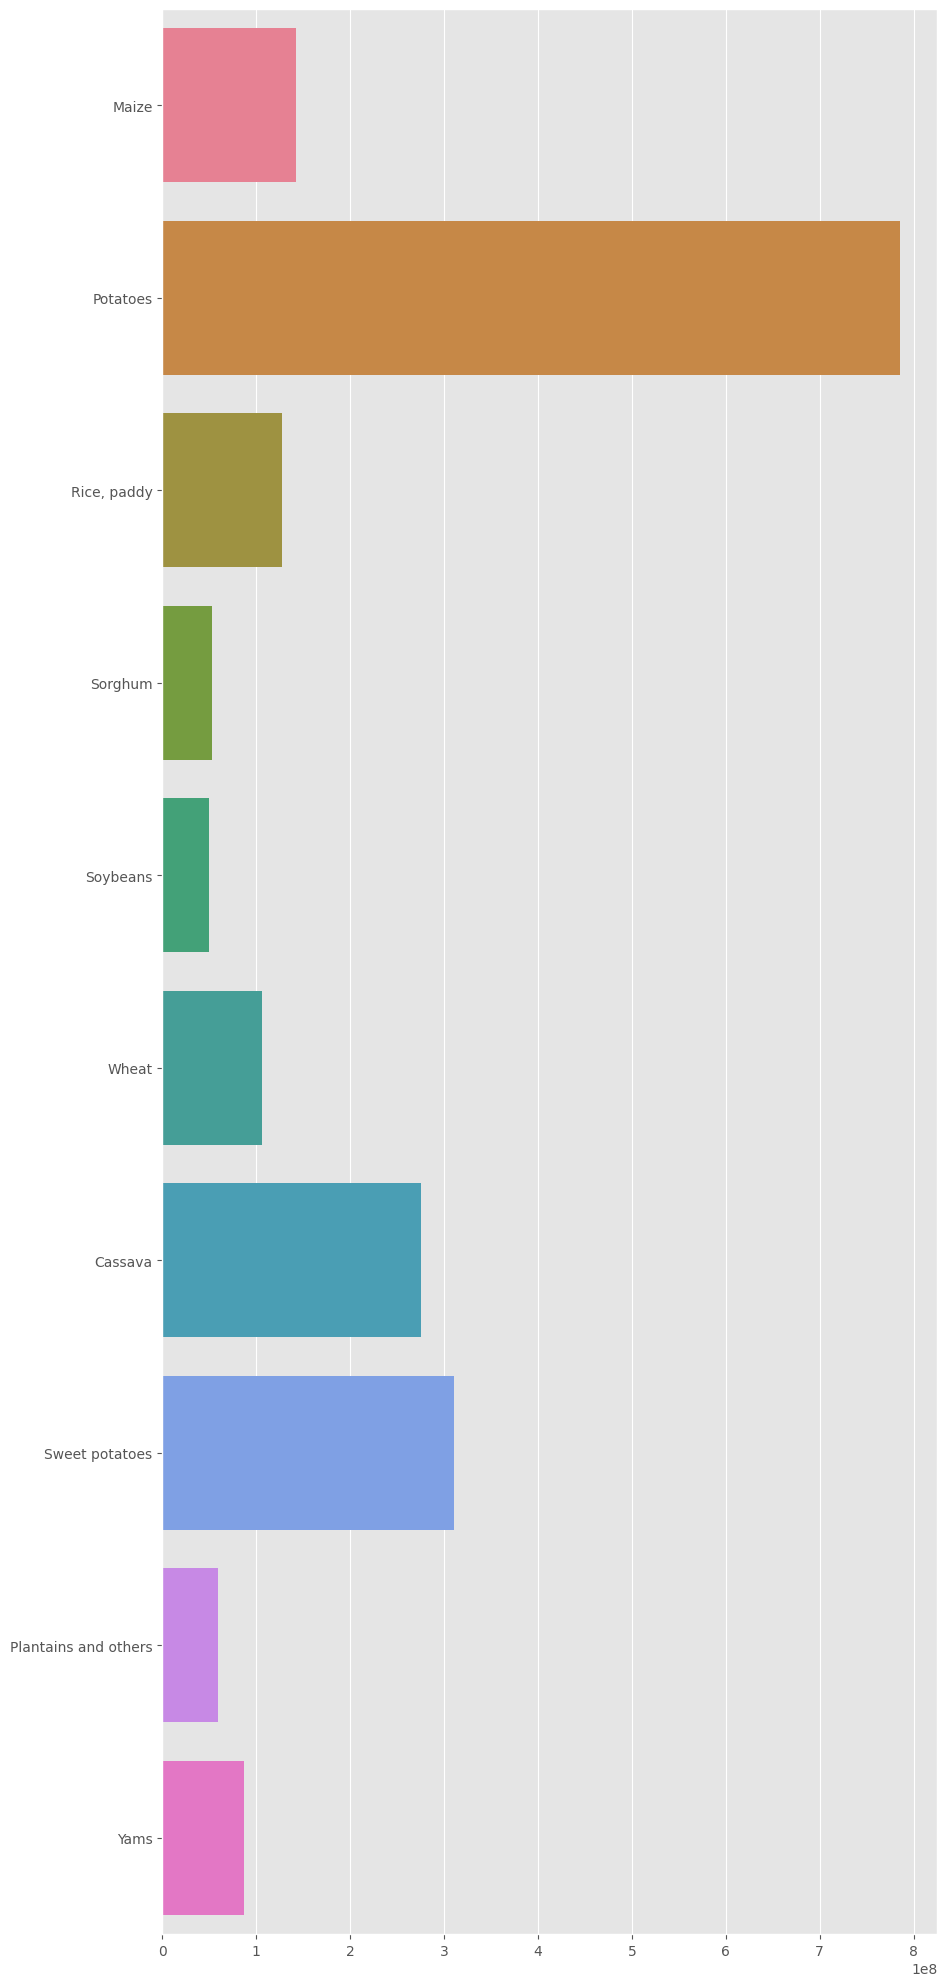

In [ ]:
plt.figure(figsize=(10,25))
sns.barplot(y=crops, x=yield_per_crop, hue=crops, dodge=False)
plt.show()

# **Building the Model**

In [ ]:
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [ ]:
df.columns

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp'],
      dtype='object')

In [ ]:
col = ['Year', 'average_rain_fall_mm_per_year','pesticides_tonnes', 'avg_temp', 'Area', 'Item', 'hg/ha_yield']

In [ ]:
df = df[col]

In [ ]:
df.head()

,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Area,Item,hg/ha_yield
0,1990,1485.0,121.0,16.37,Albania,Maize,36613
1,1990,1485.0,121.0,16.37,Albania,Potatoes,66667
2,1990,1485.0,121.0,16.37,Albania,"Rice, paddy",23333
3,1990,1485.0,121.0,16.37,Albania,Sorghum,12500
4,1990,1485.0,121.0,16.37,Albania,Soybeans,7000


In [ ]:
X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

In [ ]:
X.shape

(25932, 6)

In [ ]:
y.shape

(25932,)

In [ ]:
sampled_df = stratified_crop_sampling(df, n_samples=2000)
X = sampled_df.drop('hg/ha_yield', axis=1)
y = sampled_df['hg/ha_yield']

# Split the sampled data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ohe = OneHotEncoder(drop='first')
scale = StandardScaler()
numeric_features = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
categorical_features = ['Area', 'Item']
preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScale', StandardScaler(), numeric_features),
        ('OneHotEncode', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
X_train_dummy = preprocessor.fit_transform(X_train)
X_test_dummy = preprocessor.transform(X_test)

In [ ]:
preprocessor.get_feature_names_out(col[:-1])

array(['StandardScale__Year',
       'StandardScale__average_rain_fall_mm_per_year',
       'StandardScale__pesticides_tonnes', 'StandardScale__avg_temp',
       'OneHotEncode__Area_Algeria', 'OneHotEncode__Area_Angola',
       'OneHotEncode__Area_Argentina', 'OneHotEncode__Area_Armenia',
       'OneHotEncode__Area_Australia', 'OneHotEncode__Area_Austria',
       'OneHotEncode__Area_Azerbaijan', 'OneHotEncode__Area_Bahamas',
       'OneHotEncode__Area_Bahrain', 'OneHotEncode__Area_Bangladesh',
       'OneHotEncode__Area_Belarus', 'OneHotEncode__Area_Belgium',
       'OneHotEncode__Area_Botswana', 'OneHotEncode__Area_Brazil',
       'OneHotEncode__Area_Bulgaria', 'OneHotEncode__Area_Burkina Faso',
       'OneHotEncode__Area_Burundi', 'OneHotEncode__Area_Cameroon',
       'OneHotEncode__Area_Canada',
       'OneHotEncode__Area_Central African Republic',
       'OneHotEncode__Area_Chile', 'OneHotEncode__Area_Colombia',
       'OneHotEncode__Area_Croatia', 'OneHotEncode__Area_Denmark',
   

# **Training the Model**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

In [ ]:
models = {
    'LinearRegression' : LinearRegression(),
    'Decision Tree' : DecisionTreeRegressor(),
    'KNN' : KNeighborsRegressor(),
    'Random Forest' : RandomForestRegressor()
}

scores = []
for name, md in models.items():

    #train the model
    md.fit(X_train_dummy, y_train)

    #make the predictions
    y_predict = md.predict(X_test_dummy)

    #model evaluation
    scores.append({
        'Model': name,
        'Scores' : md.score(X_test_dummy, y_test),
        'MAE': mean_absolute_error(y_test, y_predict),
        'R2': r2_score(y_test, y_predict)
    })
    print(f"{name} - Scores: {md.score(X_test_dummy,y_test)} , MAE: {mean_absolute_error(y_test, y_predict)}, R2: {r2_score(y_test, y_predict)}")

LinearRegression - Scores: 0.7267525322697487 , MAE: 27883.77052879954, R2: 0.7267525322697487
Decision Tree - Scores: 0.7915324837649504 , MAE: 14599.4625, R2: 0.7915324837649504
KNN - Scores: 0.5950187501047992 , MAE: 33993.0025, R2: 0.5950187501047992
Random Forest - Scores: 0.8794967987391125 , MAE: 13293.91145, R2: 0.8794967987391125


In [ ]:
#Table views of the Scores, MAE and R2
scores = pd.DataFrame(scores, columns=['Model', 'Scores', 'MAE', 'R2'])

In [ ]:
scores

,Model,Scores,MAE,R2
0,LinearRegression,0.726753,27883.770529,0.726753
1,Decision Tree,0.791532,14599.462500,0.791532
2,KNN,0.595019,33993.002500,0.595019
3,Random Forest,0.879497,13293.911450,0.879497


Text(0.5, 1.0, 'Model Scores')

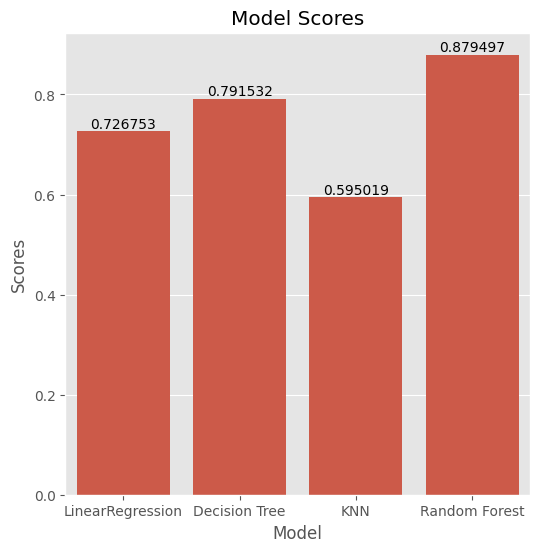

In [ ]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='Model', y='Scores', data=scores)
ax.bar_label(ax.containers[0])
ax.set_title('Model Scores')

In [ ]:
#Prediction using Random Forest
rf = RandomForestRegressor()
rf.fit(X_train_dummy, y_train)
rf.predict(X_test_dummy)

array([ 71059.02, 125866.92, 233996.09, 149775.23,  50027.84,  30781.47,
       143418.26,  79074.35,   6797.48,  74403.51,  28940.34,  29938.94,
        28467.87,  24234.91,  66594.04,  27879.69,  27822.86,  77543.05,
        30967.03,  19908.29,  21566.94,  17566.65, 111078.11,  23300.83,
        99642.48,  42010.4 ,  57504.95, 186483.39,  26773.68, 236143.01,
        24150.15, 282330.21,  22908.54,  19778.75, 264554.61, 126628.15,
        20523.27,  37032.71, 114117.4 ,  43633.21,  10305.4 ,  29691.3 ,
        22914.88,  15977.23,  18164.95,  16971.89,  46861.33,  26525.52,
       111349.15, 241609.37,  35956.63,  32339.21,  49612.14,  17940.57,
        17468.8 ,  88442.82, 229769.77,  26849.47,  93863.31,  10389.88,
        25104.7 ,  17875.3 , 307141.27,  36828.17,  61335.17, 117603.18,
        11150.65, 222467.88,  39312.67,  15812.36,  23249.38,  28599.42,
        19137.36, 147547.92,  91659.12, 215572.31, 312986.34,  16394.88,
       254844.69,  78421.63,  87431.93,  28141.31, 

In [ ]:
df.columns

Index(['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes',
       'avg_temp', 'Area', 'Item', 'hg/ha_yield'],
      dtype='object')

In [ ]:
df.head(10)

,Year,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,Area,Item,hg/ha_yield
0,1990,1485.0,121.0,16.37,Albania,Maize,36613
1,1990,1485.0,121.0,16.37,Albania,Potatoes,66667
2,1990,1485.0,121.0,16.37,Albania,"Rice, paddy",23333
3,1990,1485.0,121.0,16.37,Albania,Sorghum,12500
4,1990,1485.0,121.0,16.37,Albania,Soybeans,7000
5,1990,1485.0,121.0,16.37,Albania,Wheat,30197
6,1991,1485.0,121.0,15.36,Albania,Maize,29068
7,1991,1485.0,121.0,15.36,Albania,Potatoes,77818
8,1991,1485.0,121.0,15.36,Albania,"Rice, paddy",28538
9,1991,1485.0,121.0,15.36,Albania,Sorghum,6667


# **Prediction**

In [ ]:
def prediction(Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp, Area, Item):
    input_data = pd.DataFrame({
        'Year': [Year],
        'average_rain_fall_mm_per_year': [average_rain_fall_mm_per_year],
        'pesticides_tonnes': [pesticides_tonnes],
        'avg_temp': [avg_temp],
        'Area': [Area],
        'Item': [Item]
    })

    # Transform the features
    transform_features = preprocessor.transform(input_data)

    # Make prediction
    predicted_yield = rf.predict(transform_features)

    return predicted_yield[0]

In [ ]:
result = prediction(1990,1485.0,121.0,16.37,'Albania','Soybeans')

# **Prediction Results**

In [ ]:
result

8228.8